In [6]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [7]:
# ================================
# 1️⃣ LOAD DATASET
# ================================
dataset_name = "Team-SknAI/SknAI_300_v3_11Labels"
datasets = load_dataset(dataset_name)
datasets = datasets["train"].train_test_split(test_size=0.2, stratify_by_column="label")

# ================================
# 2️⃣ DEFINE TRANSFORMATIONS
# ================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ================================
# 3️⃣ CUSTOM DATASET CLASS
# ================================
class SkinDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        try:
            img = self.dataset[idx]["image"]
            img = Image.fromarray(np.array(img).astype("uint8"))
            img = img.convert("RGB")
            img = self.transform(img)
            label = torch.tensor(self.dataset[idx]["label"], dtype=torch.long)
            return img, label
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            return torch.zeros(3, 224, 224), torch.tensor(0)

# ================================
# 4️⃣ CREATE DATA LOADERS
# ================================
train_dataset = SkinDataset(datasets["train"], transform)
val_dataset = SkinDataset(datasets["test"], transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


In [8]:
# ================================
# 5️⃣ DEFINE MODEL
# ================================
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        self.model = timm.create_model("densenet121", pretrained=True, num_classes=num_classes)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

num_classes = len(datasets["train"].features["label"].names)
model = DenseNet121Model(num_classes)


In [ ]:
# ================================
# 6️⃣ TRAINING SETUP
# = ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)


In [ ]:
# ================================
# 7️⃣ TRAINING LOOP WITH TRACKING
# ================================
EPOCHS = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)
    
    scheduler.step()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%")


c:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/15 - Loss: 50.2211, Train Accuracy: 62.08%
Epoch 2/15 - Loss: 16.6230, Train Accuracy: 87.05%
Epoch 3/15 - Loss: 8.7955, Train Accuracy: 92.88%
Epoch 4/15 - Loss: 5.6130, Train Accuracy: 95.45%
Epoch 5/15 - Loss: 4.0976, Train Accuracy: 96.93%
Epoch 6/15 - Loss: 3.0363, Train Accuracy: 97.95%
Epoch 7/15 - Loss: 1.5454, Train Accuracy: 99.02%
Epoch 8/15 - Loss: 1.1156, Train Accuracy: 99.55%
Epoch 9/15 - Loss: 0.5983, Train Accuracy: 99.62%
Epoch 10/15 - Loss: 0.6350, Train Accuracy: 99.55%
Epoch 11/15 - Loss: 0.6012, Train Accuracy: 99.66%
Epoch 12/15 - Loss: 0.6553, Train Accuracy: 99.70%
Epoch 13/15 - Loss: 0.6253, Train Accuracy: 99.62%
Epoch 14/15 - Loss: 0.7542, Train Accuracy: 99.39%
Epoch 15/15 - Loss: 0.6655, Train Accuracy: 99.62%


In [11]:
# ================================
# 8️⃣ EVALUATION & METRICS
# ================================
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

val_accuracy = 100 * correct / total
val_accuracies.append(val_accuracy)
print(f"Test Accuracy: {val_accuracy:.2f}%")

Test Accuracy: 89.55%


Classification Report:
                                            precision    recall  f1-score   support

                                     Acne       0.91      0.82      0.86        60
                                 Alopecia       0.95      0.93      0.94        60
                                   Eczema       0.82      0.85      0.84        60
      Fungal Infection (Nail or ringworm)       0.94      0.98      0.96        60
                                   Herpes       0.77      0.82      0.79        60
                              Normal Skin       0.92      1.00      0.96        60
                                Psoriasis       0.83      0.80      0.81        60
                                  Rosacea       0.88      0.88      0.88        60
Viral Infection (Chicken-pox or shingles)       0.93      0.93      0.93        60
                                 Vitiligo       0.95      0.92      0.93        60
                                    Warts       0.96      0.92

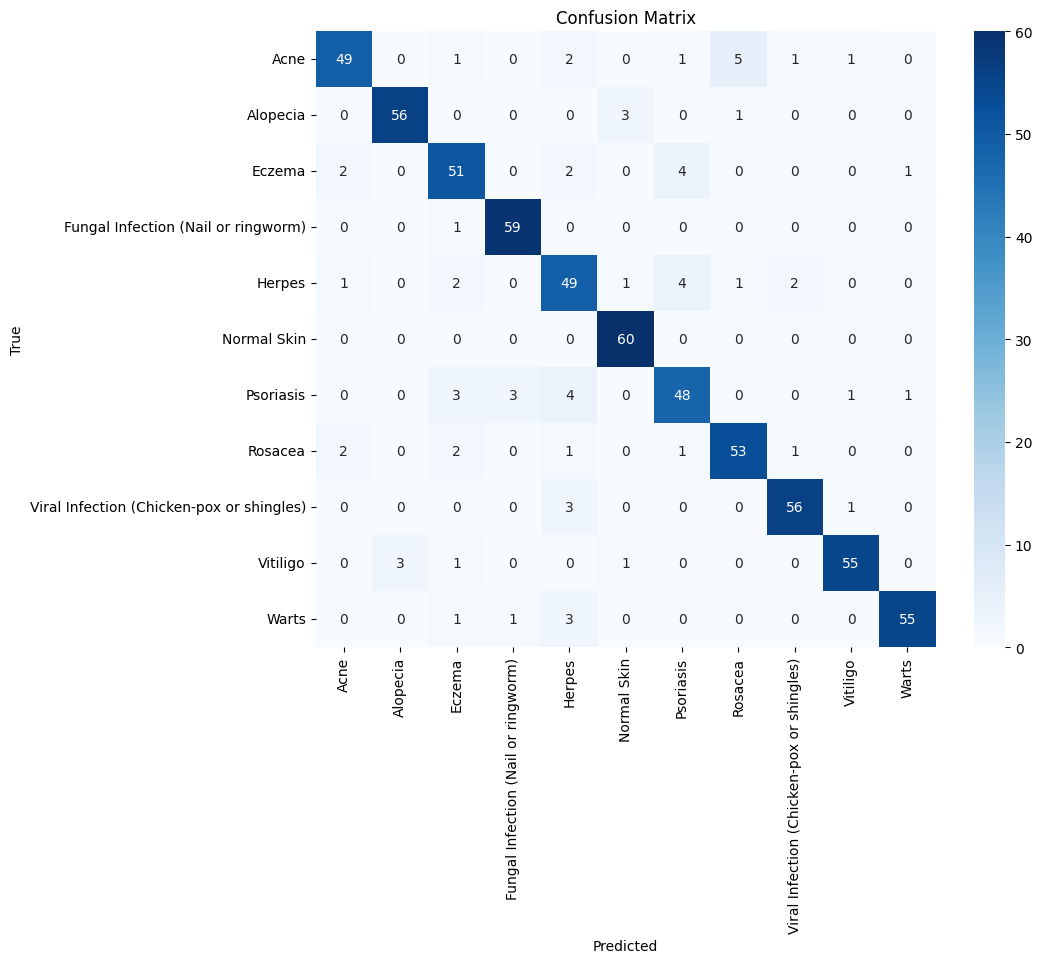

In [12]:
# ================================
# 9️⃣ CLASSIFICATION REPORT & CONFUSION MATRIX
# ================================
labels = datasets["train"].features["label"].names
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=labels))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

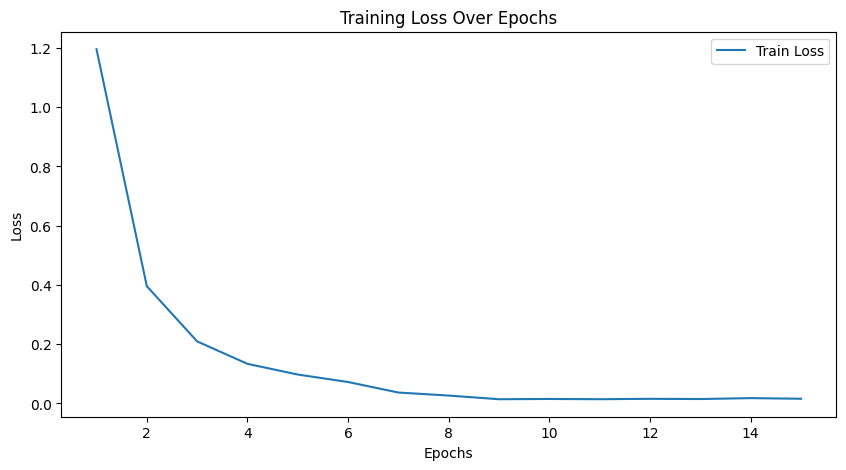

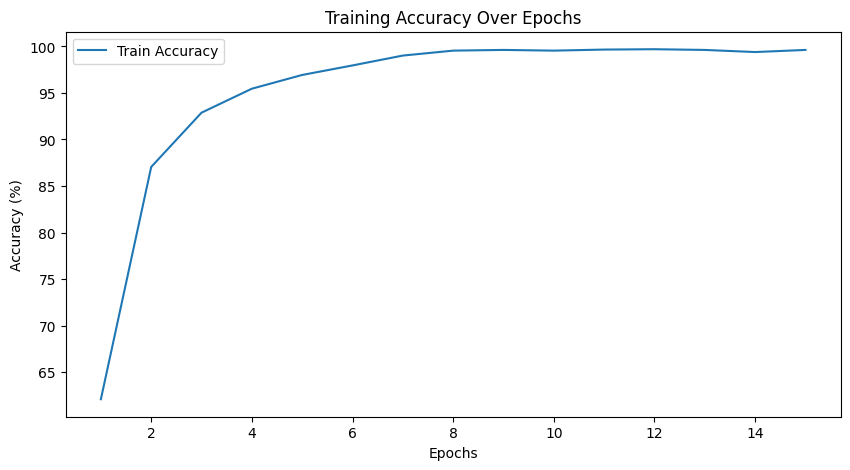

In [13]:
# ================================
# 🔟 PLOT ACCURACY & LOSS
# ================================
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# ================================
# ✅ SAVE MODEL
# ================================
torch.save(model.state_dict(), "densenet121_9242.pth")
print("✅ Model saved successfully!")
